Proyecto 1: Minería de Texto para Turismo

Andrea Quintanilla Carranza

In [4]:
# Tools
import random
import glob

import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import seaborn as sns
from nltk.corpus import stopwords  # Corpora de palabras vacías
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from IPython.display import display
from scipy.sparse import hstack
from nltk.tokenize import RegexpTokenizer
from nltk import Text

Semillas:

In [5]:
seed = 111
random.seed(seed)
np.random.seed(seed)


Lectura de datos:

In [6]:
csv_folder ="./Datos/"

# Lista de nombres con lugares
site_names_list = []
for f_page in glob.glob(csv_folder + "*"):
    name = site = ' '.join(f_page[8:-4].split('_'))
    site_names_list.append(name)

# Diccionario nombre_lugar - tabla
sites_df_dict= dict()
for f_page in glob.glob(csv_folder + "*"):  # glob.glob regresa todos las direcciones de todos los archivos de esa carpeta
    table = pd.read_csv(f_page, engine='python')
    site = ' '.join(f_page[8:-4].split('_'))
    sites_df_dict[site] = table

Organización y limpieza de datos:

In [13]:


class CleanTables():

    def __init__(self, tables_dict: dict, tokenizer=None):

        # Conjunto con puntuación (se omitirán del modelo)
        self.punct = set(string.punctuation)
        self.punct.update({'¡', '¿', '@usuario', '<url>', '...'})
        self.punct.remove('@')
        self.tokenizer = tokenizer if tokenizer else self.default_tokenizer

        # Tablas
        tables_dict = self.make_corpus_col(tables_dict)
        tables_dict = self.make_label_col(tables_dict)
        tables_dict = self.make_site_col(tables_dict)
        tables_dict = self.format_dates(tables_dict)
        tables_dict = self.make_age_label_col(tables_dict)

        self.tables_dict = tables_dict
        self.tables_names = tables_dict.keys()
        self.joined_tables = pd.concat(list(tables_dict.values()))



    def get_same_cols_from_tables(self, col_name:list, from_small_tables=True)->dict:
        cols = dict()
        if from_small_tables:
            for site, df in self.tables_dict.items():
                cols[site] = df[col_name]
        else:
            cols["all sites"] = self.joined_tables[col_name]
        return cols

    def is_invalid_word(self, word: str) -> bool:

        word = word.lower()

        is_punct = word in self.punct

        is_digit = word.isnumeric()

        return is_punct or is_digit


    def default_tokenizer(self, doc: str) -> list:

        """
        Tokenizador default sólo utliza espacios para separar.
        """

        return doc.split(" ")

    def clean_doc(self, doc)->list:

        filtered_doc_list =  [w.replace('"', '').lower() for w in self.tokenizer(doc) if not self.is_invalid_word(w)]

        clean_doc = " ".join(filtered_doc_list)

        return clean_doc


    def make_corpus_col(self, tables_dict: dict)->dict:

        new_tables_dicts = dict()

        for t_name, tab in tables_dict.items():

            clean_docs_list = []

            title_col = tab['Título de la opinión']
            opinion_col = tab['Opinión']

            for title, opinion in zip(title_col, opinion_col):
                doc = title+' '+opinion
                clean_docs_list.append(self.clean_doc(doc))

            tab["Corpus"] = clean_docs_list

            new_tables_dicts[t_name] = tab

        return new_tables_dicts

    @staticmethod
    def classify_score(score:int):
        if score<3:
            return "negativo", -1
        elif score == 3:
            return "neutro", 0
        else:
            return "positivo", 1

    @staticmethod
    def make_site_col(tables_dict: dict)->dict:

        new_tables_dicts = dict()

        for t_name, tab in tables_dict.items():

            site_col = [t_name] * len(tab)
            tab["Sitio"] = site_col

            new_tables_dicts[t_name] = tab

        return new_tables_dicts

    @staticmethod
    def classify_age(age:float):
        if age < 35.0:
            return "joven"
        elif age > 55.0:
            return "viejo"
        else:
            return "adulto"

    @staticmethod
    def make_label_col(tables_dict: dict)->dict:

        new_tables_dicts = dict()

        for t_name, tab in tables_dict.items():

            labels_col = []
            score_col = []

            scores_col = tab['Escala']

            for score in scores_col:
                label, label_ord = CleanTables.classify_score(score)
                labels_col.append(label)
                score_col.append(label_ord)

            tab["Etiqueta"] = labels_col
            tab["Num. etiqueta"] = score_col

            new_tables_dicts[t_name] = tab

        return new_tables_dicts

    @staticmethod
    def make_age_label_col(tables_dict: dict)->dict:

        new_tables_dicts = dict()

        for t_name, tab in tables_dict.items():

            labels_col = []

            age_col = tab['Edad']


            for age in age_col:

                label = CleanTables.classify_age(age)

                labels_col.append(label)


            tab["Etiqueta edad"] = labels_col

            new_tables_dicts[t_name] = tab

        return new_tables_dicts

    def format_dates(self, tables_dict: dict)->dict:

        new_tables_dicts = dict()

        for t_name, tab in tables_dict.items():

            tab["Fecha"] = pd.to_datetime(tab["Fecha"])

            new_tables_dicts[t_name] = tab

        return new_tables_dicts


    def get_subgroups_corpora_n_labels(self, category:string, col_name:string)->dict:
        subgroups_corporas = dict()

        for site, df in self.tables_dict.items():

            corpus = df.loc[df[col_name]==category, "Corpus"]
            labels = df.loc[df[col_name]==category, "Etiqueta"]
            subgroups_corporas[site] = (list(corpus), list(labels))

        return subgroups_corporas

    # # select columns of dataframe
    # age_sex = titanic[["Age", "Sex"]]
    #
    # # filter specific rows from a DataFrame
    # above_35 = titanic[titanic["Age"] > 35]
    # class_23 = titanic[titanic["Pclass"].isin([2, 3])]
    # class_23 = titanic[(titanic["Pclass"] == 2) | (titanic["Pclass"] == 3)]
    #
    # # just known data
    # age_no_na = titanic[titanic["Age"].notna()]
    #
    # # select rows and columns: first argument rows, second cols
    # adult_names = titanic.loc[titanic["Age"] > 35, "Name"]
    # titanic.iloc[9:25, 2:5]


tokenizer = RegexpTokenizer("[^\d\W]+")
manage_tables = CleanTables(sites_df_dict, tokenizer.tokenize)

In [8]:
manage_tables.joined_tables.head()

,Género,Edad,Nacional ó Internacional,Calificación,Escala,Número de aportaciones,Título de la opinión,Opinión,País,Idioma,Dispositivo,Fecha,Corpus,Etiqueta,Num. etiqueta,Sitio,Etiqueta edad
0,Femenino,64.0,Internacional,Muy bueno,4,175.0,"""Punto central""","""Basílica muy bien conservada, punto central e...",Colombia,Español,Móvil,2018-05-13,punto central basílica muy bien conservada pun...,positivo,1,basilica colegiata,viejo
1,Masculino,59.0,Internacional,Excelente,5,306.0,"""The most important church in this colonial to...","""The Basilica (Guanajuato does not have a Cath...",Colombia,Inglés,PC,2018-05-08,the most important church in this colonial tow...,positivo,1,basilica colegiata,viejo
2,Femenino,26.0,Internacional,Excelente,5,106.0,"""Y uno de los símbolos de Guanajuato""","""Edificio de la iglesia amarilla es un abigarr...",Corea del Sur,Coreano,PC,2018-05-05,y uno de los símbolos de guanajuato edificio d...,positivo,1,basilica colegiata,joven
3,Masculino,50.0,Internacional,Excelente,5,62.0,"""Beautiful and a must see""","""A must see place in town and very nice to go ...",Estados Unidos,Inglés,PC,2018-05-01,beautiful and a must see a must see place in t...,positivo,1,basilica colegiata,adulto
4,Femenino,55.0,Internacional,Regular,3,59.0,"""Nice""","""Not particularly impressive, but if you like ...",Estados Unidos,Inglés,PC,2018-04-29,nice not particularly impressive but if you li...,neutro,0,basilica colegiata,adulto


Clase para manejo de bolsas de palabras:

In [14]:
class Bow():

    def __init__(self, corpus, tr_y, n_gram_range, min_df=0, maxfeatures=None):

        stopwords_en_sp = stopwords.words('spanish') + stopwords.words('english')

        self.vectorizer = TfidfVectorizer(stop_words=stopwords_en_sp, ngram_range=n_gram_range, norm='l2',
                                          max_features=maxfeatures, min_df=min_df)
        self.corpus = corpus

        self.tr_y = tr_y

        self.bow = self.vectorizer.fit_transform(self.corpus)

        self.vocab = self.vectorizer.get_feature_names()

        self.topic_encoded_df = None

        self.topic_names = None

        self.encoding_matrix = None


    def get_bow_as_df(self):
        return pd.DataFrame(self.bow.toarray(), columns = self.vocab)

    def get_most_important_features(self, m:int)->(list, dict):

        feats = SelectKBest(chi2, k=m) # Palabras más relevantes para discriminar entre las palabras de interés

        feats.fit(self.bow, self.tr_y)

        best_idx = feats.get_support(indices=True)

        # self.bow = SelectKBest(chi2, k=m).fit_transform(self.bow, self.tr_y)


        scores = feats.scores_

        return best_idx, {self.vocab[i]:scores[i] for i in best_idx}

    def plt_cloud_m_words(self, m:int):
        best_idx, word_score_dict = self.get_most_important_features(m)
        wordcloud = WordCloud()
        wordcloud.fit_words(word_score_dict)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        pass

    def calculate_lsa(self, n_topics=3, n_words_to_show=10):

        self.topic_names = ["Topic "+ str(i+1) for i in range(n_topics)]
        svd = TruncatedSVD(n_components=n_topics)
        lsa = svd.fit_transform(self.bow)

        self.topic_encoded_df = pd.DataFrame(lsa, columns=self.topic_names)

        print("topic_encoded_df dims = ", self.topic_encoded_df.shape)
        self.topic_encoded_df["Corpus"] = self.corpus
        m_rows_df = self.topic_encoded_df.iloc[0:n_words_to_show, :] # test.iloc[0:2, :]
        display(m_rows_df[["Corpus"]+self.topic_names])
        # display(self.topic_encoded_df)


        self.encoding_matrix = pd.DataFrame(svd.components_, index=self.topic_names,

                                   columns=self.vocab).T

    def sort_n_show_encoding_by_n_topic_m_rows(self, n, m):
        if not (0 < n <= len(self.topic_names)):
            print(str(n)+ ' is out of range, sorting by first topic')
            n = 1

        n -= 1
        self.encoding_matrix["abs"] = np.abs(self.encoding_matrix[self.topic_names[n]])
        self.encoding_matrix = self.encoding_matrix.sort_values("abs", ascending=False)
        m_rows_df = self.encoding_matrix.iloc[0:m, :] # test.iloc[0:2, :]
        display(m_rows_df[self.topic_names[n]].T)

        pass


    def plot_first_pc_by_cat(self, slice_with_labels, class_names:list):

        self.encoding_matrix["Cat"] = slice_with_labels

        fig, ax = plt.subplots()
        for val in self.encoding_matrix.class_names[0].unique():
            topic_1 = self.encoding_matrix[self.encoding_matrix.Cat == val][self.topic_names[0]].values
            topic_2 = self.encoding_matrix[self.encoding_matrix.Cat == val][self.topic_names[1]].values
            color = "red" if val else "green"
            label = class_names[0] if val else class_names[1]
            ax.scatter(topic_1, topic_2, c=color, alpha=0.3, label=label)

        ax.set_xlabel("First Topic")
        ax.set_ylabel("Second Topic")
        ax.axvline(linewidth=0.5)
        ax.axhline(linewidth=0.5)
        ax.legend()
        display(fig)

        pass

    def actualize_to_most_important_features(self, m, func)->None:

        feats = SelectKBest(func, k=m) # Palabras más relevantes para discriminar entre las palabras de interés

        feats.fit(self.bow, self.tr_y)

        best_idx = feats.get_support(indices=True)

        self.vocab = [self.vocab[i] for i in best_idx]

        self.bow = SelectKBest(func, k=m).fit_transform(self.bow, self.tr_y)

        self.vectorizer = None

        self.topic_encoded_df = None

        self.topic_names = None

        self.encoding_matrix = None

        pass


## I. Actividades

1. Construya estadísticas básicas respecto a la opinión de cada lugar turistico. Considere scores de 4 a 5 como positivos,
calificaciones de 3 como neutros y las de 2 a 1 como negativos.

a) y b) Promedios de calificación por lugar, y desviaciones estándar en los scores. Y
longitud promedio de opiniones y desviacones estándar.

In [15]:
def scale_to_score(scale):
    if scale > 4.5:
        return "Excelente"
    if scale > 3.5:
        return "Bueno"
    if scale > 2.5:
        return "Regular"
    if scale > 1.5:
        return "Malo"
    else:
        return "Pésimo"



site_scales_dict = manage_tables.get_same_cols_from_tables("Escala")
site_corpus_dict = manage_tables.get_same_cols_from_tables("Opinión")

data = []
index = []

for site, scale in site_scales_dict.items():

    mean = scale.mean()
    corpus = site_corpus_dict[site]
    corpus_lens = corpus.apply(lambda op: len(op))

    site_dict = {"Calificación promedio": scale_to_score(mean),
                 "Escala promedio": round(mean,2), "Desviación de escala": round(scale.std(),2),
                 "Longitud promedio de opiniones": corpus_lens.mean(), "Desviación de longitud opiniones":corpus_lens.std()}

    data.append(site_dict)
    index.append(site.capitalize())

stats_sites = pd.DataFrame(data, index=index)
stats_sites


,Calificación promedio,Escala promedio,Desviación de escala,Longitud promedio de opiniones,Desviación de longitud opiniones
Basilica colegiata,Bueno,4.50,0.67,227.189286,164.190560
Teatro juarez,Excelente,4.70,0.52,239.888119,151.704208
Mercado hidalgo,Bueno,3.95,0.95,263.935000,188.140734
Museo de las momias,Bueno,3.68,1.14,327.655758,260.066447
Casa de diego rivera,Bueno,4.24,0.80,277.161891,166.846241
Alhondiga,Bueno,4.45,0.75,271.788172,193.772422
Callejon del beso,Bueno,4.00,0.97,251.116912,180.005965
Jardin de la union,Excelente,4.59,0.61,248.666667,203.105184
Monumento pipila,Bueno,4.38,0.77,264.432716,199.226825
Universidad de guanajuato,Excelente,4.60,0.61,208.566667,115.317808


(c) Histogramas de edades de opiniones por lugar

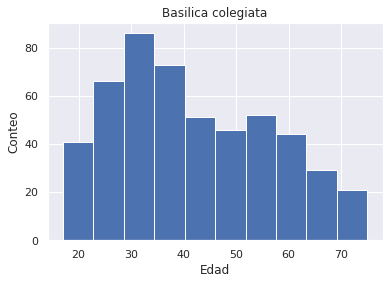

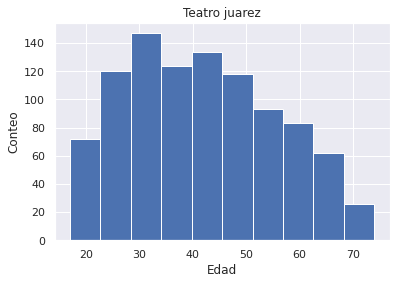

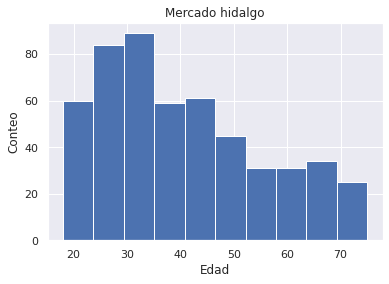

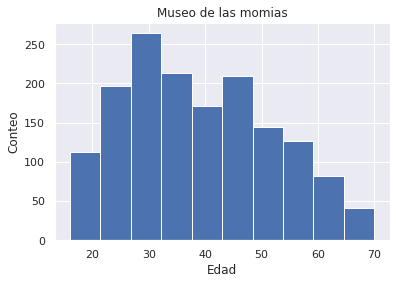

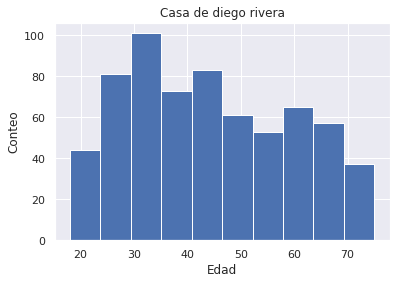

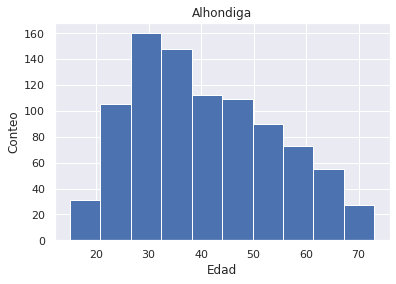

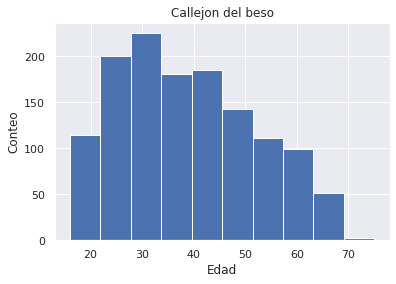

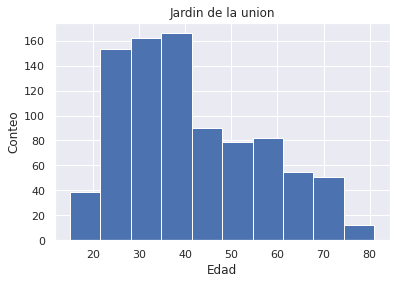

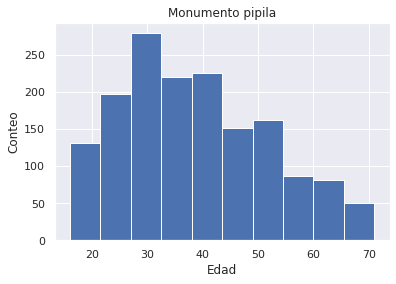

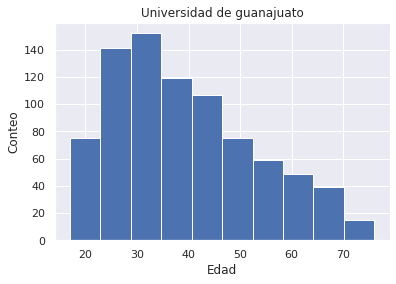

In [16]:
sns.set_theme()
for site, df in sites_df_dict.items():
    fig, ax = plt.subplots(1, 1)
    ax.set_title(site.capitalize())
    ax.set_xlabel('Edad')
    ax.set_ylabel('Conteo')
    ax.hist(df["Edad"], bins=10)
    plt.show()


(d) Histograma de tipo de visitantes (nacional o internacional) por lugar

In [ ]:
for site, df in sites_df_dict.items():
    fig, ax = plt.subplots(1, 1)
    ax.set_title(site.capitalize())
    ax.set_xlabel('Procedencia')
    ax.set_ylabel('Conteo')
    ax.hist(df["Nacional ó Internacional"], bins=3, align='mid')
    plt.show()

e) Sugiere dos más interesantes para ti.

e-i) Histograma de género de visitantes por lugar y en total.

In [ ]:
for site, df in sites_df_dict.items():
    fig, ax = plt.subplots(1, 1)
    ax.set_title(site.capitalize())
    ax.set_xlabel('Género')
    ax.set_ylabel('Conteo')
    ax.hist(df["Género"], bins=3, align='mid')
    plt.show()

In [ ]:
df = manage_tables.joined_tables
fig, ax = plt.subplots(1, 1)
ax.set_title("Género en todos los sitios")
ax.set_xlabel('Género')
ax.set_ylabel('Conteo')
ax.hist(df["Género"], bins=3, align='mid')
plt.show()

e-ii) Histograma de número de aportaciones por lugar.

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)

df = manage_tables.joined_tables
fig, ax = plt.subplots(1, 1)
ax.set_title("Aportaciones por sitio")
ax.set_xlabel('Sitio')
ax.set_ylabel('Conteo')
ax.hist(df["Sitio"], bins=10, align='mid')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()



2. Utilizando una estrategia de feature selection (se sugiere $X^2$ o ganancia de información), visualice con word_cloud
nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán
10 nubes, una por lugar.

En todos los casos se utilizó $X^2$ y bolsas con pesado TFIDF normalizadas con L2. Tanto para el feature selection
como para la construcción de las bolsas se ocupó la librería sklearnt.

In [ ]:
# Diccionario nombre_sitio-(corpora, etiquetas)
sites_corporas_n_labels = dict()

# Diccionario nombre_sitio-bow
manage_bow_sites_dict = dict()

for site, df in manage_tables.tables_dict.items():
    corpus = list(df["Corpus"])
    labels = list(df["Etiqueta"])
    sites_corporas_n_labels[site] = (corpus, labels)
    manage_bow_sites_dict[site] = Bow(corpus, labels, (1,1))


In [ ]:
m = 50
for site, bow in manage_bow_sites_dict.items():

    print("\n" + "-"*90)
    print("\n Feature selection  en "+ str(site.capitalize()) + "\n")

    bow.plt_cloud_m_words(m)



3. Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA
(componentes principales) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los
siguientes subgrupos:

a) Hombres

In [ ]:
# Diccionario nombre_sitio-(corpora_subgrupo, etiquetas_subgrupo)
subgroup_corp_n_tr_dict = manage_tables.get_subgroups_corpora_n_labels("Masculino", "Género")
manage_bow_sites_list = []
title_group = "Hombres"
# Cálculo de LSA y derivados para cada sitio
for site, (corpus, tr_y) in subgroup_corp_n_tr_dict.items():
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)
    manage_bow_sites_list.append(manage_bow)
    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)

b) Mujeres

In [ ]:
# Diccionario nombre_sitio-(corpora_subgrupo, etiquetas_subgrupo)
subgroup_corp_n_tr_dict = manage_tables.get_subgroups_corpora_n_labels("Femenino", "Género")

title_group = "Mujeres"
# Cálculo de LSA y derivados para cada sitio
for site, (corpus, tr_y) in subgroup_corp_n_tr_dict.items():
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)

    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos:")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)


c) y d) Turistas Nacionales e Internacionales

In [ ]:
# Diccionario nombre_sitio-(corpora_subgrupo, etiquetas_subgrupo)
subgroup_corp_n_tr_dict = manage_tables.get_subgroups_corpora_n_labels("Nacional", "Nacional ó Internacional")
title_group = "Turistas nacionales"

subgroup_corp_n_tr_dict_0 = manage_tables.get_subgroups_corpora_n_labels("Internacional", "Nacional ó Internacional")
title_group_0 = "Turistas internacionales"

# Cálculo de LSA y derivados para cada sitio
for site, (corpus, tr_y) in subgroup_corp_n_tr_dict.items():
    # Nacional
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)
    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos:")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)
    # Internacional
    corpus, tr_y = subgroup_corp_n_tr_dict_0[site]
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group_0)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)
    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos:")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)

e) Jóvenes.

Se tomó como criterio de juventud la movilidad física. Observando los histogramas del Pipila y la Universidad
de Guanajuato de opiniones por edad, notamos un decremento más o menos de 35 a 40. Así que como jóvenes se tomó
el rango de 0-35, porque puede que parte del atractivo sea subir caminando.
De igual, en el monumento al Pipila hay un decremento algo abrupto entre 55 y 60. Es decir, aunque tienen la
posibilidad de subir en teléferico ya no la hacen, quizás también por cuestiones de movilidad. Así que se tomará como
población de tercera edad a la mayor a 55 años.

In [ ]:
# Diccionario nombre_sitio-(corpora_subgrupo, etiquetas_subgrupo)
subgroup_corp_n_tr_dict = manage_tables.get_subgroups_corpora_n_labels("joven", "Etiqueta edad")

title_group = "Jóvenes"
# Cálculo de LSA y derivados para cada sitio
for site, (corpus, tr_y) in subgroup_corp_n_tr_dict.items():
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)

    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos:")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)

f) Mayores.

Por lo dicho en el inciso anterior, se tomará como población de tercera edad a la mayor a 55 años.

In [ ]:
# Diccionario nombre_sitio-(corpora_subgrupo, etiquetas_subgrupo)
subgroup_corp_n_tr_dict = manage_tables.get_subgroups_corpora_n_labels("viejo", "Etiqueta edad")

title_group = "Tercera edad"
# Cálculo de LSA y derivados para cada sitio
for site, (corpus, tr_y) in subgroup_corp_n_tr_dict.items():
    print("\n" + "-"*90)
    print("\n                          LSA en "+ str(site.capitalize()) + " " + title_group)
    n_gram_range = (1,1)
    manage_bow = Bow(corpus, tr_y, n_gram_range)

    n_topics = 3
    print("\n Ejemplos de opiniones descritas por tópicos:")
    manage_bow.calculate_lsa(n_topics, 3)
    m_to_show = 10
    for i in range(n_topics):
        print("\n" + "Palabras con mayores pesos para el tópico "+str(i+1))
        manage_bow.sort_n_show_encoding_by_n_topic_m_rows(i+1, m_to_show)



4. Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre
las palabras más asociadas a sus opiniones negativas utilizando $\Xi^2(c_i, p_i)$. Puede usar
funciones de sklearn o hacerlo tal como en las diapositivas del autor Ricardo Baeza (di-
apositivas dónde está lo de información mutua).

In [ ]:
def calculate_n_ip(vocab:list, corpora_p:list):
    """
    Calcula el número n_ip: de documentos en que cada término i aparece en la clase p

    :param vocab: feature_names
    :param corpora_p: textos de entrenamiento de la clase p
    :return: vector con valores n_ip, donde n_ip del término i está en el índice = columna
    del diccionario dict_indices
    """

    n_ip_vector = np.zeros(len(vocab))

    for doc in corpora_p:
        set_doc = set(doc.split(" "))
        for word in set_doc:
            if word in vocab:
                word_idx = vocab.index(word)
                n_ip_vector[word_idx] += 1

    return n_ip_vector


def get_most_important_features_class_0(vocab, n_rank, tr_0, tr_1)->dict:

    n_i0 = np.array(calculate_n_ip(vocab, tr_0))

    n_i1 = np.array(calculate_n_ip(vocab, tr_1))

    n_i = n_i0 + n_i1

    N_t = len(tr_0) + len(tr_1)

    n_0 = len(tr_0)

    # Métrica Chi^2 clase 0
    chi_0_num = N_t * (N_t * n_i0 - n_0 * n_i) ** 2
    chi_0_denum = n_0 * n_i * (N_t - n_0) * (N_t - n_i)
    scores = chi_0_num / chi_0_denum

    # Ranking
    word_score_dict = dict()
    min_info = np.min(scores)

    for n in range(n_rank):
        i = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
        word_score_dict[vocab[i[0]]] = np.max(scores)
        scores[i] = min_info

    return word_score_dict

def plt_cloud_word(word_score_dict):
    wordcloud = WordCloud()
    wordcloud.fit_words(word_score_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    pass

In [ ]:
# # Diccionario nombre_sitio-(corpora, etiquetas)
# sites_corporas_n_labels = dict()
#
# # Diccionario nombre_sitio-bow
# manage_bow_sites_dict = dict()
#
# for site, df in manage_tables.tables_dict.items():
#     corpus = list(df["Corpus"])
#     labels = list(df["Etiqueta"])
#     sites_corporas_n_labels[site] = (corpus, labels)
#     manage_bow_sites_dict[site] = Bow(corpus, labels, (1,1))

In [ ]:
# Diccionario nombre_sitio-(corpora_clase_0, corpora_clase_1)
corpuss = dict()
for site, df in manage_tables.tables_dict.items():
    corpus_0 = df.loc[df['Etiqueta']=='negativo', "Corpus"]
    corpus_1 = df.loc[(df['Etiqueta']=='positivo') | (df['Etiqueta']=='neutro'), "Corpus"]
    corpuss[site] = (corpus_0, corpus_1)

In [ ]:
for site, (corpus_0, corpus_1) in corpuss.items():
    n_rank = 50
    site_capitalize = site.capitalize()
    print(" ")
    print("-"*90)
    print("Nube de top "+ str(n_rank) + " palabras en " + site_capitalize)
    print(" ")
    vocab = manage_bow_sites_dict[site].vocab
    word_score_dict = get_most_important_features_class_0(vocab, n_rank, corpus_0, corpus_1)
    plt_cloud_word(word_score_dict)


5. Para cada uno de los 10 sitios turísticos construya tres Bolsas de Palabras de la siguiente manera:


In [ ]:
# Cálculo de tfidf para cada palabra
def calculate_feature_tfidf(X, y):
    return np.sum(X.toarray(), axis=0)


i) 1000 términos con mayor peso tfidf

In [ ]:
m = 1000
for site, manage_bow in manage_bow_sites_dict.items():
    manage_bow.actualize_to_most_important_features(m, calculate_feature_tfidf)


ii) 2000 bigramas con mayor tfidf

In [ ]:
# Construcción de bolsas de bigramas totales y filtrado de mayor tfidf

manage_bow_bigrams_dict = dict()
m = 2000
n_gram = 2
for site, (corpus, labels) in sites_corporas_n_labels.items():
    manage_bow = Bow(corpus, labels, n_gram_range=(n_gram,n_gram))
    manage_bow.actualize_to_most_important_features(m, calculate_feature_tfidf)
    manage_bow_bigrams_dict[site] = manage_bow

iii) 1000 trigramas con mayor tfidf

In [ ]:
# Construcción de bolsas de bigramas totales y filtrado de mayor tfidf

manage_bow_trigrams_dict = dict()
m = 1000
n_gram = 3
for site, (corpus, labels) in sites_corporas_n_labels.items():
    manage_bow = Bow(corpus, labels, n_gram_range=(n_gram,n_gram))
    manage_bow.actualize_to_most_important_features(m, calculate_feature_tfidf)
    manage_bow_trigrams_dict[site] = manage_bow

iv) Finalmente, concatene las tres representaciones que fueron calculadas de forma independiente,
con sus propios tfidfs según su espacio y su propio L2. Y sobre todo ese espacio concatenado de 4000
características aplique ganancia de información o $\Xi^2$ y obtenga los 1000 features más relevantes.
Muestre una nube de palabras con el top 50 features relevantes para cada lugar turistico.

In [ ]:
n_feature_select = 1000
n_cloud =  50

for site, manage_bow in manage_bow_sites_dict.items():

    one_bow = manage_bow.bow
    two_bow = manage_bow_bigrams_dict[site].bow
    tri_bow = manage_bow_trigrams_dict[site].bow

    conct_bow = hstack([one_bow, two_bow, tri_bow])

    feats = SelectKBest(chi2, k=n_feature_select)
    feats.fit(conct_bow, manage_bow.tr_y)
    best = feats.get_support(indices=True)
    scores = feats.scores_
    vocab = manage_bow.vocab + manage_bow_bigrams_dict[site].vocab + manage_bow_trigrams_dict[site].vocab

    cap_site = site.capitalize()

    print(" ")
    print("-"*90)

    print("\n" +  cap_site + ":" + str(n_feature_select) + " features más relevantes ")
    word_score_dict = {vocab[i]:scores[i] for i in best}
    plt_cloud_word(word_score_dict)


    print("\n" +  cap_site + ":" + str(n_cloud) + " features más relevantes ")
    word_score_dict_cloud = {vocab[i]:scores[i] for i in best[0:n_cloud]}
    plt_cloud_word(word_score_dict_cloud)


6. Muestre la ocurrencia temporal de las 10 palabras con más ganancia de información
de TODO el dataset para cada sitio turístico. Aquí se sugiere usar la gráfica de estilo de
los discursos de primer año de los presidentes en USA dada como ejemplo en NLTK. La
idea sería tener una gráfica por sitio turístico y la ocurrencia marcada en azul del top 10
palabras de con mayor ganancia de información o chi en todo el dataset.

In [ ]:
# Tabla de todos los sitios por fecha

joined_table_all_sites = manage_tables.joined_tables

joined_table_all_sites = joined_table_all_sites.sort_values("Fecha", ascending=True)

In [ ]:
#Corpus y etiquetas

ord_corpus_all_sites = joined_table_all_sites["Corpus"]

labels_all_sites = joined_table_all_sites["Etiqueta"]

In [ ]:
# Cálculo de palabras más relevantes

manage_bow = Bow(ord_corpus_all_sites, labels_all_sites, (1,1))

m = 10
best_idx, words_to_dispersion = manage_bow.get_most_important_features(m)
words_to_dispersion = list(words_to_dispersion.keys())

In [ ]:
from nltk import Text

# Lista de todas las palabras de todos los sitios por orden temporal y etiquetas
split_ord_docs = [doc.split() for doc in ord_corpus_all_sites]

ord_words = [w for s_d in split_ord_docs for w in s_d]

t_words = Text(ord_words)

In [ ]:
# Gráfica de dispersión

t_words.dispersion_plot(words_to_dispersion)

7. Diseñe un análisis temporal (formato libre) que muestre opiniones positivas, negativas
y neutras a través de los meses y años para todos los sitios turísticos. En pocas
palabras mostrar la evolución de las opiniones a través del tiempo.

In [ ]:
# Tabla de todos los sitios ordenados por fecha

joined_table_all_sites = manage_tables.joined_tables

joined_table_all_sites = joined_table_all_sites.sort_values("Fecha", ascending=True)


In [ ]:
#Etiquetas 'positivo', 'neutro', 'negativo' ordenadas por tiempo
labels_all_sites = joined_table_all_sites["Etiqueta"]

# Lista de todas las palabras de todos los sitios por orden temporal y etiquetas
# split_ord_docs = [doc.split() for doc in ord_corpus_all_sites]
#
# ord_words = [w for s_d in split_ord_docs for w in s_d]

t_words = Text(labels_all_sites)

# Gráfica de dispersión

words_to_dispersion = ['positivo', 'neutro', 'negativo']

t_words.dispersion_plot(words_to_dispersion)


In [ ]:
# Cumulative Independendent Scores
def get_cumulative(scores):
    dates2plot, scores2plot, cumulative = [], [], 0.
    for i in range(len(scores)):
        date, _ = scores[i]
        cumulative += 1
        dates2plot.append(date)
        scores2plot.append(np.log10(cumulative))

    return dates2plot, scores2plot

for site, df in manage_tables.tables_dict.items():
    cap_site = site.capitalize()

    print(" ")
    print("-"*90)

    print("\n" +  cap_site + ": distribución temporal de tipos de opiniones" )
    df = df.sort_values("Fecha", ascending=True)
    dates_pd = df["Fecha"]
    scores_pd = df["Num. etiqueta"]

    sorted_scores_negative = [
        (date, score)
        for date, score, date_is_null, score_is_null in zip(dates_pd, scores_pd, dates_pd.isna(), scores_pd.isna())
        if (not date_is_null) and (not score_is_null) and (score == -1)
    ]

    sorted_scores_neutral = [
        (date, score)
        for date, score, date_is_null, score_is_null in zip(dates_pd, scores_pd, dates_pd.isna(), scores_pd.isna())
        if (not date_is_null) and (not score_is_null) and (score == 0)
    ]

    sorted_scores_positive = [
        (date, score)
        for date, score, date_is_null, score_is_null in zip(dates_pd, scores_pd, dates_pd.isna(), scores_pd.isna())
        if (not date_is_null) and (not score_is_null) and (score == 1)
    ]

    fig, ax1 = plt.subplots(1, 1)
    positive_dates2plot, positive_scores2plot = get_cumulative(sorted_scores_positive)
    neutral_dates2plot, neutral_scores2plot = get_cumulative(sorted_scores_neutral)
    negative_dates2plot, negative_scores2plot = get_cumulative(sorted_scores_negative)

    ax1.set_title('Log-conteo de positivos - negativos')
    ax1.set_ylabel('Log-score')
    ax1.plot_date(positive_dates2plot, positive_scores2plot, 'g--', alpha=0.5, label='Positivos')
    ax1.plot_date(neutral_dates2plot, neutral_scores2plot, 'b--', alpha=0.5, label='Neutrales')
    ax1.plot_date(negative_dates2plot, negative_scores2plot, 'r--', alpha=0.5, label='Negativos')
    plt.legend(loc='upper left')
    plt.show()

## II. Preguntas

Conteste lo más detallado posible lo sigu-
iente, dando argumentos y conclusiones claras según su análi-
sis. Cada respuesta entre 150 y 300 palabras.

En las primeras 5 preguntas se observaron principalmente como criterios para responder los resultados en
las estadísticas generales del primer ejercicio y las palabras con mayores pesos de las primeras componetes
o tópicos del método de LSA.

1. ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de ello?

Pareciera ser el Museo de las Momias. En primer lugar porque tiene la mayor desviación estándar en la escala.
Y aunque esa desviación se podría explicar con que sencillamente se tienen más muestras de ese sitio, no es así
porque el segundo lugar con mayor cantidad de opiniones es el Jardín Unión y en promedio está calificado como excelente.

Además, ya que la longitud de las opiniones entre los lugares calificados como excelentes, pareciera que los
comentarios de mayor tamaño pudierán estar ligados a valoraciones bajas o complejas, y ese lugar también tiene mayor
longitud promedio y desviación estándar promedio de longitud.

Por otro lado el LSA muestra en general palabras descriptivas y positivas en todos los sitios, más algunas excepciones
de 1 a 3 palabras en los siguientes sitios: la Alhóndiga, las Momias, el Museo Diego Rivero, el Callejón del Beso
y el Pipila, hay algunas palabras negativas como: lleno, corto, small, mucha-gente, subir (con loadings negativos
y en contraste con loadings positivos de adjetivos positivos).

Además, en la distribución temporal de los sitios, vemos que todos fueron mayomente positivos a lo largo del tiempo,
salvo en momias, mercado hidalgo y alhóndiga.
En la alhóndiga y en el mercado hidalgo eventualmente las valoraciones negativos y positivos se separaron, pero
en el museo de las momias la tendencia parece ser establemente cercanda entre ambos grupos.

2. En cuanto al sitio más polémico, ¿Cómo es la diferencia de opinión y temas entre
turistas nacionales e internacionales?

Primero notemos en el histograma de Lugar de Procedencia del Museo de las Momias que ambas grupos
(nacionales e internacionales) están balanceados. Así que en ese sentido, no hay diferencia.
Por otro lado en el LSA, notamos que en ambas clases las palabras sulen ser descriptivas y positivas,
exceptuando las palabras de la tercera componente o tópico de Internacionales. En ella,
se observan palabras positivas-neutras con loadings positivos, y palabras que pueden ser negativas
con loadings negativos, como lo son: dead, bodies y people. Esta última palabra, ya que se
distingue de adjetivos positivos podría estar relacionada con que hay mucha gente y que eso se valora
negativamente.

3. ¿Cuál diría que es el sitio que le gusta más a las mujeres y por qué?

Por las estadísticas del ejercicio 1 me inclinaría en primer lugar, por el Teatro Juárez, suponiendo
que tienen la misma preferencia que el promedio. Y si se quiere ver su distinción respecto a los hombres
me inclinaría por la Casa de Diego Rivera.

La razón del Teatro Juárez es simplemente que es el sitio con la mayor puntuación promedio. Y para la teoría de
casa de Diego Rivera, vista en contraste con los hombres. Notemos  primero que en casi todos los lugares hay menos
muestras de mujeres. Esto se puede deber a que tienden a escribir menos opiniones en internet o a que van menos a lugares turísticos, o ambas.
Por otro lado, se puede observar que enlos lugares donde los géneros están más equilibrados es en
la Casa de Diego Rivera y en el Callejón del Beso. Lo cuál podría indicar que les agrada más ir allí.
Sin embargo, lo del Callejón se puede explicar porque se suele ir en pareja, así que quizás en cuestión de gusto
prefieran la Casa de Diego Rivera.

Por otro lado, el LSA no aporta mucha infomación en este caso ya que todas las palabras en todos los sitios
suelen ser positivas o descriptivas. Sin embargo, en se observa que tanto en la Basílica como en el Teatro
Juárez son mayormente positicas.

Concluyo que el lugar que más les gusta es el Teatro.

4. ¿Cuál diría que es el sitio que le gusta más a las personas jóvenes y por qué?

Ya que hay pocas opiniones de menores de 20 y por un ejercicio anterios, como rango para el análisis
se tomó de 20 a 35. A los lugares que más jóvenes de (20-35) van en contraste conlos adultos es al Mercado, al Callejón y
al Jardín, se nota una disminución abrupta y se ve más o menos horizontal hacia la izquierda.
El LSA es muy similar al de las mujeres. Para el JArdín Unión se notan sólo palabras positivas
así que me inclinaría por el Jardín Unión, o igual que el promedio, considerando
que son la mayoría, es decir por el Tatro Juaŕez.

6. ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó
de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)
En todos los lugares hay más jóvenes (internet).
En los primero años hay menos opiniones (internet).
Juarez, Univ, y Jardín obtuvieron excelentes y son relativamente cercanos.

En la selección de características relevantes de cada sitio con Bow TFIDF.
Se puede observar que como los adjetivos negativos son más útiles para dicriminar que los positivos.
Eso se puede explicar teniendo en cuenta que quizás en los comentarios neutros o negativos pueden a aparecer adejtivos positivos
en como "aunque es bonita", "pero es interesante", pero en los comentarios positivos (con calificaciones usuales
de excelente o muy bueno) es inusual que aparezcan adjetivos negativos.

LSA hace distinción entre inglés y español, usualmente pertenecen a tópicos distintos.
Sin embargo no hace gran distinción entre palabras positivas y negativas, eso puede explicarse porque es
un algoritmo no supervisado, pero aún así, debido a que estamos haciendo análisis a nivel de palabra
está distinguiendo entre los dos grandes grupos de inglés y español.

Es extraño ver como un feature relevate a la palabra momias, aunque es sumamente común y se está realizando pesado
TFIDF, se puede explicar considerando lo que observamos antriormente sobre los adejtivos negativos
 (que son relevantes para la discriminación) y si los comentarios acerca de ellas suelen se negativos.

